### Import libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:82.5% !important}</style>'))

In [2]:
import numpy as np
import pandas as pd

import time
import datetime
from datetime import timedelta

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Paths to directories and files

In [5]:
TRAIN_DATASET_TASK = 'data/X_data.csv'
YTRAIN_DATASET_TASK = 'data/Y_train.csv'
SUBMISSION_TASK = 'data/Y_submit.csv'

### Loading data

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_TASK, delimiter=';')
ytrain_df = pd.read_csv(YTRAIN_DATASET_TASK, delimiter=';', header=None, names=['time', 'target'])
test_df = pd.read_csv(SUBMISSION_TASK, delimiter=';', header=None, names=['time', 'target'])
submission_df = pd.read_csv(SUBMISSION_TASK, delimiter=';', header=None, names=['time', 'target'])

### Exploratory Data Analysis

In [7]:
# Просмотр первых 5 строк
train_df.head()

,Unnamed: 0,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85000,9.22000
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51000,9.22000
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99000,9.22000
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34000,9.22000
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04000,9.22000


In [8]:
# Просмотр последних 5 строк
train_df.tail()

,Unnamed: 0,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
2103836,2018-12-31 23:56:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,157.20000,8.44000
2103837,2018-12-31 23:57:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,160.40000,8.44000
2103838,2018-12-31 23:58:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,160.14000,8.44000
2103839,2018-12-31 23:59:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,162.96000,8.44000
2103840,2019-01-01 00:00:00,271,261,265,353,359,353,481,449,491,325,328,328,277,276,280,159.73000,7.35000


In [9]:
# Краткая информация о DataFrame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103841 entries, 0 to 2103840
Data columns (total 18 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  object 
 1   T_data_1_1  int64  
 2   T_data_1_2  int64  
 3   T_data_1_3  int64  
 4   T_data_2_1  int64  
 5   T_data_2_2  int64  
 6   T_data_2_3  int64  
 7   T_data_3_1  int64  
 8   T_data_3_2  int64  
 9   T_data_3_3  int64  
 10  T_data_4_1  int64  
 11  T_data_4_2  int64  
 12  T_data_4_3  int64  
 13  T_data_5_1  int64  
 14  T_data_5_2  int64  
 15  T_data_5_3  int64  
 16  H_data      float64
 17  AH_data     float64
dtypes: float64(2), int64(15), object(1)
memory usage: 288.9+ MB


In [10]:
# Размерность DataFrame
print(f'train_df.shape = {train_df.shape[0]} rows, {train_df.shape[1]} cols')
print(f'ytrain_df.shape = {ytrain_df.shape[0]} rows, {ytrain_df.shape[1]} cols')
print(f'submission_df.shape = {submission_df.shape[0]} rows, {submission_df.shape[1]} cols')

train_df.shape = 2103841 rows, 18 cols
ytrain_df.shape = 29184 rows, 2 cols
submission_df.shape = 5808 rows, 2 cols


In [11]:
# Анализ пропусков
train_df.isnull().sum()

Unnamed: 0    0
T_data_1_1    0
T_data_1_2    0
T_data_1_3    0
T_data_2_1    0
T_data_2_2    0
T_data_2_3    0
T_data_3_1    0
T_data_3_2    0
T_data_3_3    0
T_data_4_1    0
T_data_4_2    0
T_data_4_3    0
T_data_5_1    0
T_data_5_2    0
T_data_5_3    0
H_data        0
AH_data       0
dtype: int64

In [12]:
# Датчики температур
numerical_features = train_df.columns.values[1:16]

In [13]:
# Статистика датчиков температур
train_df[numerical_features].describe()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3
count,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000,2103841.00000
mean,250.18218,250.09151,250.25358,349.77560,349.72176,349.82816,501.16107,501.10922,501.23355,349.31962,349.43898,350.02992,249.74877,249.63113,249.69371
std,32.11661,30.82451,30.69125,42.25961,40.67887,37.98444,63.25732,63.37164,62.23294,39.30562,39.19989,40.18360,30.73298,30.50021,30.74629
min,-198.00000,-122.00000,-107.00000,-703.00000,-958.00000,-191.00000,-775.00000,-759.00000,-613.00000,-514.00000,-471.00000,-609.00000,-89.00000,-125.00000,-163.00000
25%,229.00000,229.00000,229.00000,328.00000,328.00000,328.00000,464.00000,464.00000,464.00000,327.00000,328.00000,328.00000,229.00000,229.00000,229.00000
50%,250.00000,250.00000,250.00000,350.00000,350.00000,350.00000,502.00000,502.00000,502.00000,349.00000,350.00000,350.00000,249.00000,250.00000,250.00000
75%,272.00000,272.00000,272.00000,372.00000,372.00000,372.00000,538.00000,538.00000,539.00000,372.00000,372.00000,372.00000,270.00000,271.00000,271.00000
max,724.00000,762.00000,665.00000,1302.00000,1179.00000,889.00000,1587.00000,2505.00000,1319.00000,1177.00000,1244.00000,944.00000,905.00000,738.00000,624.00000


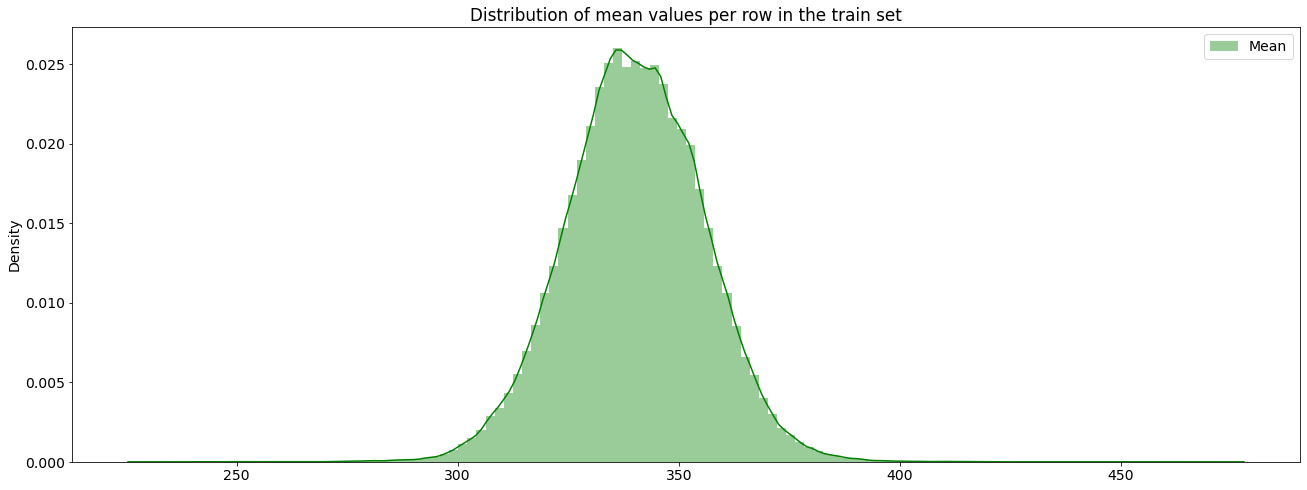

In [14]:
plt.figure(figsize=(22, 8))
plt.title('Distribution of mean values per row in the train set')
sns.distplot(train_df[numerical_features].mean(axis=1), color='green', kde=True, bins=120, label='Mean')
plt.legend()
plt.show()

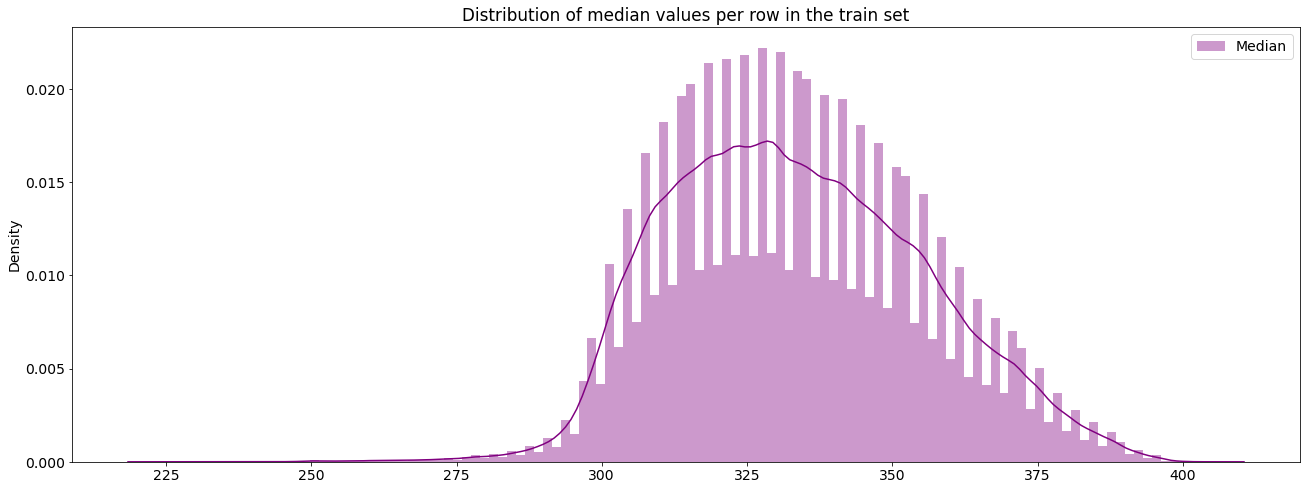

In [15]:
plt.figure(figsize=(22, 8))
plt.title('Distribution of median values per row in the train set')
sns.distplot(train_df[numerical_features].median(axis=1), color='purple', kde=True, bins=120, label='Median')
plt.legend()
plt.show()

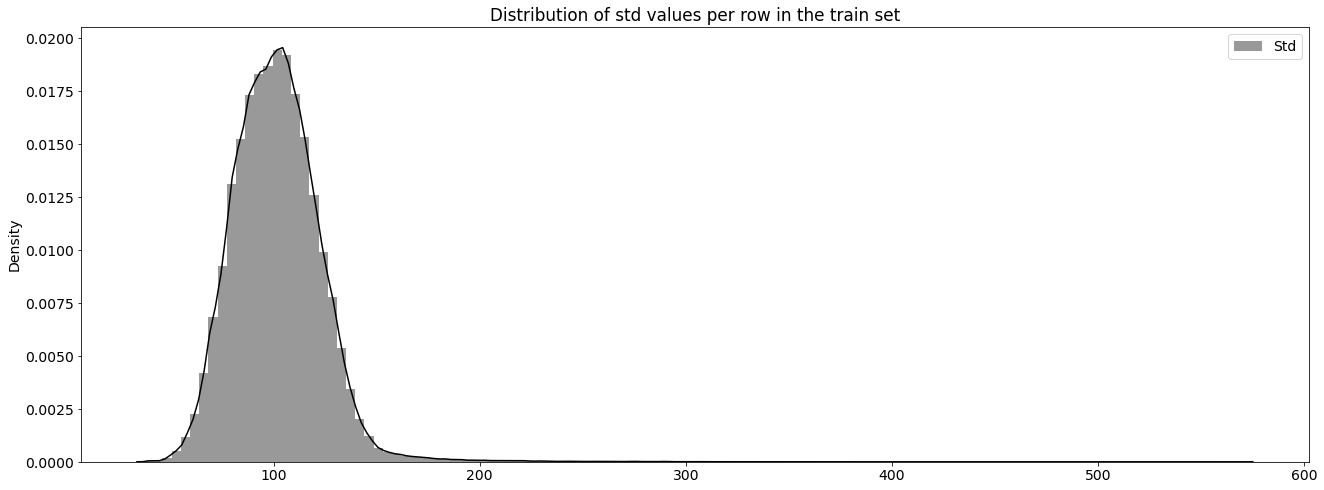

In [16]:
plt.figure(figsize=(22, 8))
plt.title('Distribution of std values per row in the train set')
sns.distplot(train_df[numerical_features].std(axis=1), color='black', kde=True, bins=120, label='Std')
plt.legend()
plt.show()

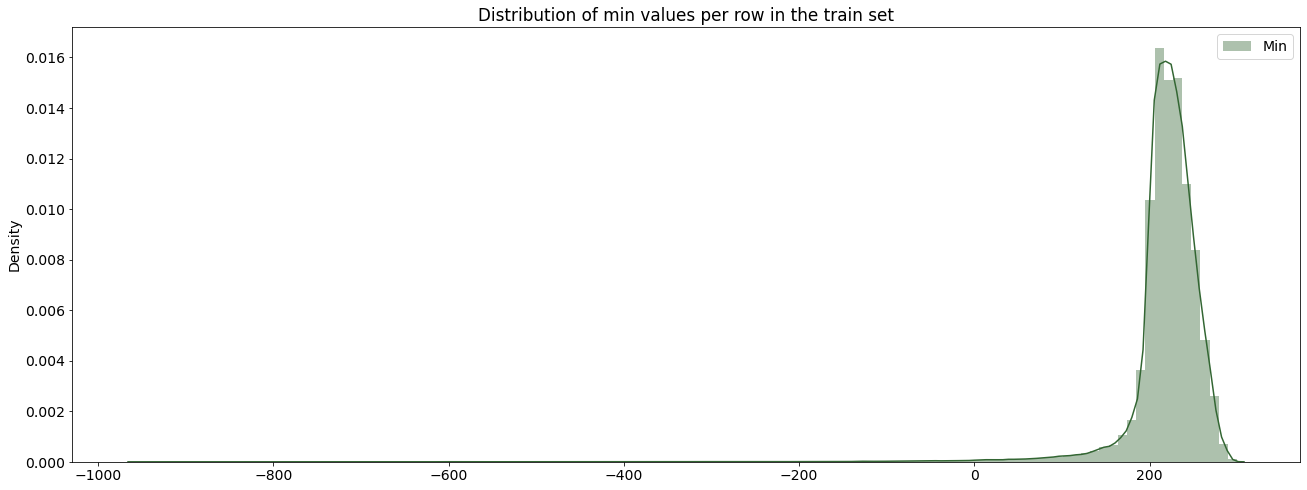

In [17]:
plt.figure(figsize=(22, 8))
plt.title('Distribution of min values per row in the train set')
sns.distplot(train_df[numerical_features].min(axis=1), color='#336633', kde=True, bins=120, label='Min')
plt.legend()
plt.show()

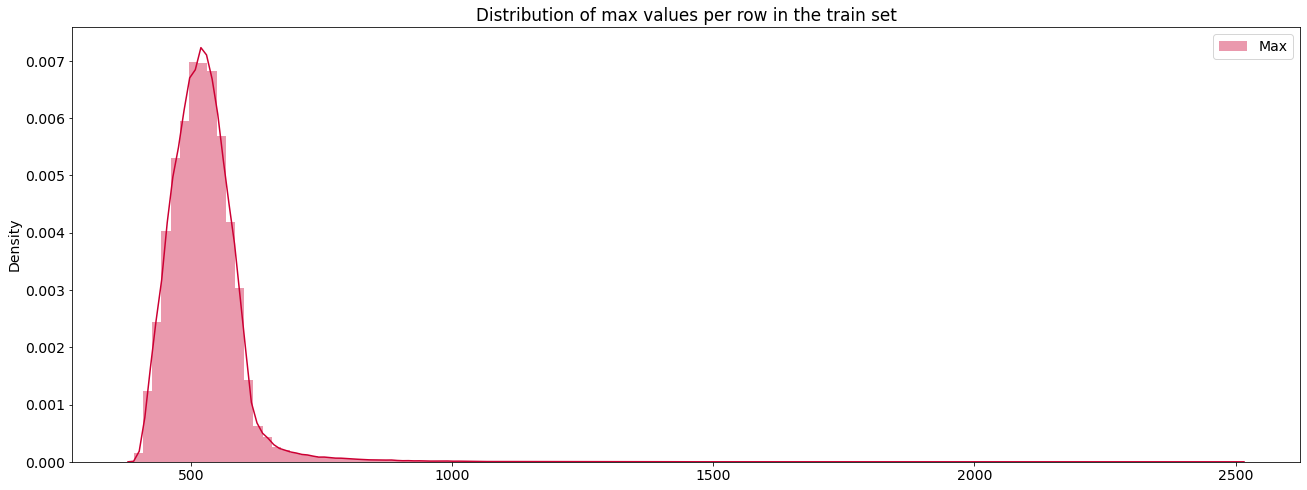

In [18]:
plt.figure(figsize=(22, 8))
plt.title('Distribution of max values per row in the train set')
sns.distplot(train_df[numerical_features].max(axis=1), color='#CC0033', kde=True, bins=120, label='Max')
plt.legend()
plt.show()

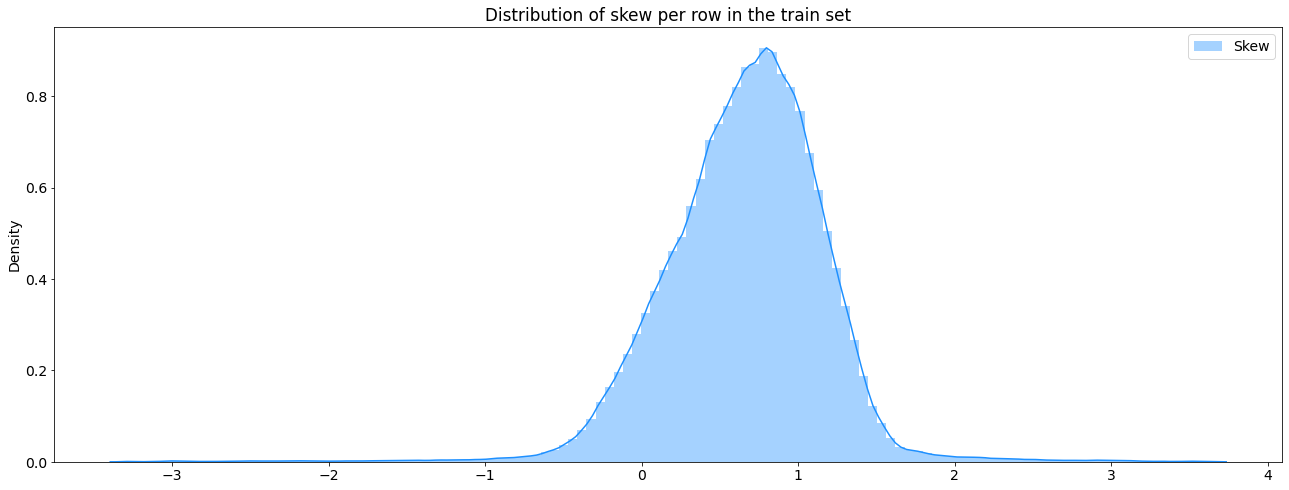

In [19]:
plt.figure(figsize=(22, 8))
plt.title('Distribution of skew per row in the train set')
sns.distplot(train_df[numerical_features].skew(axis=1), color='DodgerBlue', kde=True, bins=120, label='Skew')
plt.legend()
plt.show()

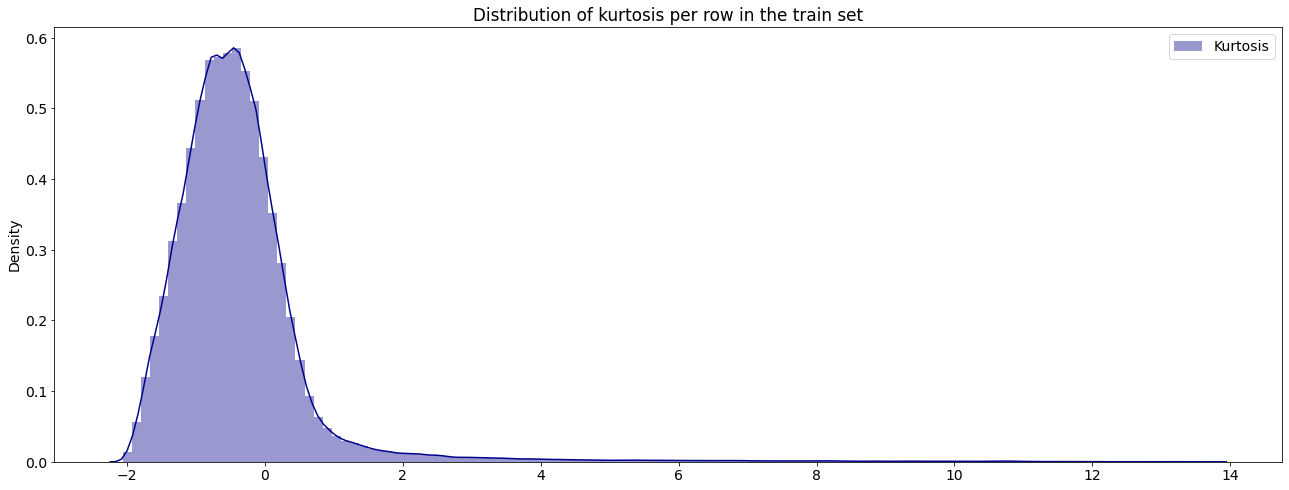

In [20]:
plt.figure(figsize=(22, 8))
plt.title('Distribution of kurtosis per row in the train set')
sns.distplot(train_df[numerical_features].kurtosis(axis=1), color='darkblue', kde=True, bins=120, label='Kurtosis')
plt.legend()
plt.show()

In [21]:
# Данные о высоте слоя сырья и его влажности
numerical_features2 = train_df.columns.values[16:18]

In [22]:
# Статистика данных о высоте слоя сырья и его влажности
train_df[numerical_features2].describe()

,H_data,AH_data
count,2103841.00000,2103841.00000
mean,174.71699,7.49937
std,14.43613,1.14803
min,141.49000,2.89000
25%,162.44000,6.73000
50%,174.40000,7.51000
75%,187.01000,8.27000
max,207.83000,11.84000


### Feature engineering

Если ориентироваться на данные о влажности сырья, которые измеряются при входе сырья в машину, то наблюдаем, что процесс обжига в машине начинается в 00 минут и заканчивается в 59 минут каждого часа, далее на выходе из обжиговой машины забирается проба для измерения качества продукции в лаборатории, а результат предоставляется только спустя 5 минут.

In [23]:
# Конвертирование строк в datetime
train_df = train_df.rename(index=str, columns={'Unnamed: 0': 'time'})
train_df['time'] = train_df['time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
ytrain_df['time'] = ytrain_df['time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=-65))
test_df['time'] = test_df['time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=-65))

In [24]:
# Передискретизация времени, агрегация и заполнение значений медианой
train_df = train_df.resample('H', on='time').agg({'T_data_1_1':'median', 'T_data_1_2': 'median', 'T_data_1_3': 'median', 
                                              'T_data_2_1':'median', 'T_data_2_2': 'median', 'T_data_2_3': 'median',
                                              'T_data_3_1':'median', 'T_data_3_2': 'median', 'T_data_3_3': 'median',
                                              'T_data_4_1':'median', 'T_data_4_2': 'median', 'T_data_4_3': 'median',
                                              'T_data_5_1':'median', 'T_data_5_2': 'median', 'T_data_5_3': 'median',
                                              'H_data':'median', 'AH_data': 'median'
                                             })

In [25]:
# Объединение таблиц на основе ключа - 'time'
test_df = pd.merge(train_df, test_df, on='time').rename(index=str) 
train_df = pd.merge(train_df, ytrain_df, on='time').rename(index=str) 

In [26]:
%%time
# Уменьшение количества выбросов, заполнение медианой
for i in numerical_features:
    T_data_median = train_df[i].median()
    train_df.loc[train_df[i] < 150] = T_data_median
    train_df.loc[train_df[i] > 1500] = T_data_median
    
# Уменьшение количества выбросов, заполнение медианой
for i in numerical_features:
    T_data_median = test_df[i].median()
    test_df.loc[test_df[i] < 150] = T_data_median
    test_df.loc[test_df[i] > 1500] = T_data_median

# Построение новых признаков    
for df in [train_df, test_df]:
    df['sum'] = df[numerical_features2].sum(axis=1)  
    df['med'] = df[numerical_features2].median(axis=1)    

Wall time: 364 ms


In [27]:
# Корреляционная зависимость
correlation = train_df.corr()
corr_with_target = correlation['target'].sort_values(ascending = False)

In [28]:
corr_with_target

target        1.00000
T_data_2_2    0.24340
T_data_2_3    0.23864
T_data_2_1    0.22653
T_data_4_1    0.18154
T_data_4_2    0.17430
T_data_4_3    0.17198
T_data_5_2    0.16080
T_data_5_1    0.16015
T_data_5_3    0.15890
T_data_1_2    0.14263
T_data_1_1    0.14006
T_data_1_3    0.13840
H_data       -0.05806
sum          -0.18604
med          -0.18604
AH_data      -0.24857
T_data_3_1   -0.31064
T_data_3_3   -0.31256
T_data_3_2   -0.32096
Name: target, dtype: float64

### Building the model

In [29]:
# Данные для обучения модели
numerical_features3 = train_df.columns.values[1:21]

In [30]:
numerical_features3

array(['T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'T_data_2_1',
       'T_data_2_2', 'T_data_2_3', 'T_data_3_1', 'T_data_3_2',
       'T_data_3_3', 'T_data_4_1', 'T_data_4_2', 'T_data_4_3',
       'T_data_5_1', 'T_data_5_2', 'T_data_5_3', 'H_data', 'AH_data',
       'target', 'sum', 'med'], dtype=object)

In [31]:
X = train_df[numerical_features3]
X.drop(['target'], axis=1)
y = train_df['target']

In [32]:
results_lgb = []
oof_preds_lgb = np.zeros(X.shape[0])

params_lgb = {
    'objective': 'mae',
    'boosting_type': 'gbdt', 
    'max_depth': 11,
    'learning_rate': 0.01,
    'max_bin': 264,
    'n_jobs': -1,
    'verbose': -1
}

folds = KFold(n_splits=5, random_state=2021, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X[numerical_features3].iloc[train_index], X[numerical_features3].iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_lgb = lgb.LGBMRegressor(**params_lgb, num_iterations=10000)
    
    model_lgb.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              verbose=50, early_stopping_rounds=75)

    train_predictions_lgb = model_lgb.predict(X_train)
    test_predictions_lgb = model_lgb.predict(X_test)
    oof_preds_lgb[test_index] = model_lgb.predict(X_test)

    train_score = mean_absolute_error(y_train, train_predictions_lgb)
    test_score = mean_absolute_error(y_test, test_predictions_lgb)

    lr_time = (time.time() - start_time)
    results_lgb.append((fold, train_score, test_score, lr_time))

Training fold 1
Training until validation scores don't improve for 75 rounds
[50]	training's l1: 26.1123	valid_1's l1: 26.0571
[100]	training's l1: 17.3013	valid_1's l1: 17.2307
[150]	training's l1: 11.7397	valid_1's l1: 11.7231
[200]	training's l1: 8.00306	valid_1's l1: 8.01117
[250]	training's l1: 5.42314	valid_1's l1: 5.45316
[300]	training's l1: 3.68749	valid_1's l1: 3.69979
[350]	training's l1: 2.51309	valid_1's l1: 2.50952
[400]	training's l1: 1.62493	valid_1's l1: 1.63915
[450]	training's l1: 0.949029	valid_1's l1: 0.943183
[500]	training's l1: 0.607189	valid_1's l1: 0.596669
[550]	training's l1: 0.4047	valid_1's l1: 0.392394
[600]	training's l1: 0.273233	valid_1's l1: 0.263012
[650]	training's l1: 0.186431	valid_1's l1: 0.176268
[700]	training's l1: 0.126131	valid_1's l1: 0.116168
[750]	training's l1: 0.106242	valid_1's l1: 0.0959545
[800]	training's l1: 0.0949296	valid_1's l1: 0.0843792
[850]	training's l1: 0.0877626	valid_1's l1: 0.0770701
[900]	training's l1: 0.0697758	valid

[300]	training's l1: 3.67694	valid_1's l1: 3.81871
[350]	training's l1: 2.51087	valid_1's l1: 2.6672
[400]	training's l1: 1.6238	valid_1's l1: 1.73951
[450]	training's l1: 0.947239	valid_1's l1: 1.01544
[500]	training's l1: 0.604236	valid_1's l1: 0.645319
[550]	training's l1: 0.398308	valid_1's l1: 0.424804
[600]	training's l1: 0.265239	valid_1's l1: 0.281896
[650]	training's l1: 0.179792	valid_1's l1: 0.193556
[700]	training's l1: 0.123297	valid_1's l1: 0.136745
[750]	training's l1: 0.0884998	valid_1's l1: 0.10077
[800]	training's l1: 0.0767312	valid_1's l1: 0.087646
[850]	training's l1: 0.0658437	valid_1's l1: 0.0754855
[900]	training's l1: 0.0617466	valid_1's l1: 0.0708671
[950]	training's l1: 0.0591839	valid_1's l1: 0.0679742
[1000]	training's l1: 0.0576103	valid_1's l1: 0.0662024
[1050]	training's l1: 0.0566404	valid_1's l1: 0.0651155
[1100]	training's l1: 0.0551781	valid_1's l1: 0.0634432
[1150]	training's l1: 0.0481453	valid_1's l1: 0.0549505
[1200]	training's l1: 0.0363078	vali

[2600]	training's l1: 0.0174428	valid_1's l1: 0.0180269
[2650]	training's l1: 0.017293	valid_1's l1: 0.0178761
[2700]	training's l1: 0.0172736	valid_1's l1: 0.0178567
[2750]	training's l1: 0.0172616	valid_1's l1: 0.0178447
[2800]	training's l1: 0.0171065	valid_1's l1: 0.0177082
[2850]	training's l1: 0.0170926	valid_1's l1: 0.017694
[2900]	training's l1: 0.0170882	valid_1's l1: 0.0176895
[2950]	training's l1: 0.0169288	valid_1's l1: 0.0175277
[3000]	training's l1: 0.0168433	valid_1's l1: 0.0174493
[3050]	training's l1: 0.0167979	valid_1's l1: 0.0174072
[3100]	training's l1: 0.0167665	valid_1's l1: 0.0173774
[3150]	training's l1: 0.0167644	valid_1's l1: 0.0173755
[3200]	training's l1: 0.0167638	valid_1's l1: 0.0173754
[3250]	training's l1: 0.0167459	valid_1's l1: 0.0173565
[3300]	training's l1: 0.0167412	valid_1's l1: 0.0173515
[3350]	training's l1: 0.0165816	valid_1's l1: 0.0171982
[3400]	training's l1: 0.016483	valid_1's l1: 0.0171075
[3450]	training's l1: 0.0164262	valid_1's l1: 0.017

[500]	training's l1: 0.599841	valid_1's l1: 0.596939
[550]	training's l1: 0.392419	valid_1's l1: 0.396472
[600]	training's l1: 0.262358	valid_1's l1: 0.274765
[650]	training's l1: 0.180736	valid_1's l1: 0.197001
[700]	training's l1: 0.124449	valid_1's l1: 0.142246
[750]	training's l1: 0.0805069	valid_1's l1: 0.0953866
[800]	training's l1: 0.0585937	valid_1's l1: 0.0721576
[850]	training's l1: 0.0485349	valid_1's l1: 0.061822
[900]	training's l1: 0.043808	valid_1's l1: 0.0571862
[950]	training's l1: 0.0393421	valid_1's l1: 0.0523549
[1000]	training's l1: 0.037621	valid_1's l1: 0.0506235
[1050]	training's l1: 0.0338882	valid_1's l1: 0.0461638
[1100]	training's l1: 0.0324057	valid_1's l1: 0.0444602
[1150]	training's l1: 0.0290773	valid_1's l1: 0.0405448
[1200]	training's l1: 0.0278783	valid_1's l1: 0.039313
[1250]	training's l1: 0.0269416	valid_1's l1: 0.0383809
[1300]	training's l1: 0.0262668	valid_1's l1: 0.0377002
[1350]	training's l1: 0.0258084	valid_1's l1: 0.0372348
[1400]	training'

In [33]:
best_models = pd.DataFrame((results_lgb))
best_models.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.01651,0.00921,14.02605
1,1,0.01760,0.02127,9.00103
2,2,0.01351,0.01424,9.26129
3,3,0.01846,0.01499,6.81983
4,4,0.01397,0.02371,10.90160


In [34]:
print(f'Train mean score: {round(np.mean(best_models.train_score), 4)}, std: {round(np.std(best_models.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models.test_score), 4)}, std: {round(np.std(best_models.test_score), 4)}')

Train mean score: 0.016, std: 0.002
Test mean score: 0.0167, std: 0.0052


### Results

In [35]:
test = test_df[numerical_features3]
test.drop(['target'], axis=1)
predictions = model_lgb.predict(test)

In [36]:
submission_df.drop(['target'], axis=1)
submission_df['target'] = predictions
submission_df.to_csv('submission.csv', index=False)

In [37]:
submission_df.head()

,time,target
0,2018-05-04 00:05:00,420.01672
1,2018-05-04 01:05:00,349.00000
2,2018-05-04 02:05:00,349.00000
3,2018-05-04 03:05:00,420.01672
4,2018-05-04 04:05:00,420.01672


In [38]:
submission_df.tail()

,time,target
5803,2018-12-31 19:05:00,420.01672
5804,2018-12-31 20:05:00,420.01674
5805,2018-12-31 21:05:00,420.01672
5806,2018-12-31 22:05:00,420.01672
5807,2018-12-31 23:05:00,420.01672
